In [1]:
from dataset_creation import csv_load
from aprovhots import fit_MLR, predict_data
import numpy as np
from HOTS.tools import get_loader
import matplotlib.pyplot as plt

In [2]:
path = '/home/INT/grimaldi.a/Documents/projets/WP3/2021-12-06_simulator_data/'
name = 'mixed_session_1.csv'

max_duration = 1e6

tau_cla = 3
patch_size=(32,32)
max_duration = 1e3

In [3]:
events = csv_load(path,name)

loading -> mixed_session_1.csv ...


 14%|███████████████████▊                                                                                                                      | 5594/38994 [00:58<05:18, 104.76it/s]

file corrupted at row number 5573
file corrupted at row number 5574
file corrupted at row number 5575
file corrupted at row number 5576
file corrupted at row number 5577
file corrupted at row number 5578


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38994/38994 [25:49<00:00, 25.17it/s]


In [11]:
t_index = 2
events[:,t_index] -= events[0,t_index]
events_first_patch_time = events[events[:,t_index]<max_duration*1e3]
np.save('mixed_session_1_first_events',events_first_patch_time)

In [39]:
x_index, y_index = 0, 1

width, height = 128, 128
patch_width, patch_height = patch_size
patches = []
for x in range(width//patch_width):
    for y in range(height//patch_height):
        events_patch = events[
                       (events[:,x_index]>=x*patch_width)&(events[:,x_index]<(x+1)*patch_width)&
                       (events[:,y_index]>=y*patch_height)&(events[:,y_index]<(y+1)*patch_height)]
        events_patch[:,x_index] -= x*patch_width
        events_patch[:,y_index] -= y*patch_height
        np.save(f'{x}_{y}', events_patch)
        patches.append(events_patch)

In [3]:
date = '2022-01-03'
MLR_model, losses = fit_MLR(path, date, tau_cla, patch_size=patch_size, max_duration = max_duration, kfold=5)

../Records/models/2022-01-03_RAW_3_(32, 32)_5_LR.pkl
load existing model


In [4]:
def predict_data_for_demo(model, loader):
    import torch
    from tqdm import tqdm
    
    N = patch_size[0]*patch_size[1]*2
    
    with torch.no_grad():
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        logistic_model = model.to(device)

        pbar = tqdm(total=len(loader))
        likelihood, prediction = [], []

        for X, target in loader:
            X = X[0]
            X = X.to(device)
            X = X.reshape(X.shape[0], N)
            n_events = X.shape[0]
            outputs = logistic_model(X)
            label_hat = np.argmax(outputs.cpu().numpy(),axis=1)
            likelihood.append(outputs.cpu().numpy())
            prediction.append(label_hat)
            pbar.update(1)
        pbar.close()
    return likelihood, prediction

In [5]:
import tonic, os
class Demo_Dataset(tonic.dataset.Dataset):
    '''creates a dataset from .csv files in a specific 'path'. Adapted for Synthetic dataset given by Sotiris
    '''
    classes = ["sea", "gro"]
    int_classes = dict(zip(classes, range(2)))
    sensor_size = [128, 128, 2]
    dtype = np.dtype([("x", int), ("y", int), ("t", int), ("p", int)])
    ordering = dtype.names

    def __init__(self, patch_size=(32,32), transform=tonic.transforms.NumpyAsType(int), target_transform=None):
        super(Demo_Dataset, self).__init__(transform=transform, target_transform=target_transform
        )

        #self.folder_name = f'patch_{patch_size}_duration_{max_duration}/test/'
            
        #self.location_on_system = save_to

        file_path = 'demo_files/'
            
        self.sensor_size[0], self.sensor_size[1] = patch_size[0], patch_size[1]
        
        for path, dirs, files in os.walk(file_path):
            files.sort()
            for file in files:
                if file.endswith("npy"):
                    self.data.append(np.load(os.path.join(path, file)))
                    self.targets.append([0])

    def __getitem__(self, index):
        """
        Returns:
            a tuple of (events, target) where target is the index of the target class.
        """
        events, target = self.data[index], self.targets[index]
        #this line is used in tonic package, keep and see if needed:
        events = np.lib.recfunctions.unstructured_to_structured(events, self.dtype)

        if self.transform is not None:
            events = self.transform(events)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return events, target

    def __len__(self):
        return len(self.data)

    def _check_exists(self):
        return self._is_file_present() and self._folder_contains_at_least_n_files_of_type(
            20, ".npy"
        )

In [6]:
transform = tonic.transforms.Compose([tonic.transforms.ToTimesurface(sensor_size=(32,32,2), tau=tau_cla, decay="exp")])
dataset = Demo_Dataset(transform=transform)
loader = get_loader(dataset, shuffle=False)

['0_0.npy', '0_1.npy', '0_2.npy', '0_3.npy', '1_0.npy', '1_1.npy', '1_2.npy', '1_3.npy', '2_0.npy', '2_1.npy', '2_2.npy', '2_3.npy', '3_0.npy', '3_1.npy', '3_2.npy', '3_3.npy']


In [7]:
likelihood, prediction = predict_data_for_demo(MLR_model, loader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:54<00:00, 14.68s/it]


In [14]:
dataset = Demo_Dataset()
loader = get_loader(dataset, shuffle=False)

['0_0.npy', '0_1.npy', '0_2.npy', '0_3.npy', '1_0.npy', '1_1.npy', '1_2.npy', '1_3.npy', '2_0.npy', '2_1.npy', '2_2.npy', '2_3.npy', '3_0.npy', '3_1.npy', '3_2.npy', '3_3.npy']


In [28]:
patch_width, patch_height = patch_size
x_index, y_index = 0, 1
x, y, i = 0, 0, 0
for events, target in loader:
    print(x,y)
    events[0,:,x_index] += x*patch_width
    events[0,:,y_index] += y*patch_width
    if x+y==0:
        events_stacked = events[0]
        prediction_stacked = prediction[0]
    else:
        events_stacked = np.vstack([events_stacked, events[0]])
        prediction_stacked = np.hstack([prediction_stacked, prediction[i]])
    i+=1
    y+=1
    if y==4:
        x+=1
        y=0

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3


In [29]:
events_stacked[:,3] = prediction_stacked

In [32]:
events_sorted = events_stacked[events_stacked[:, 2].argsort()]

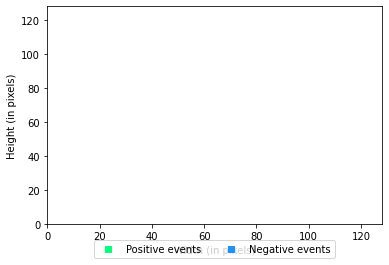

In [38]:
from visu import visualization
visualization(events_sorted, 'xytp', (128,128))